In [ ]:

#  This NoteBook contains code to run classic ML routines against a 
#  number of familiar data swets ..
#


#  Step 00: Setup

In [21]:

#  Largely code to control how print statements and related work
#

%load_ext autoreload
%autoreload 2

%xmode Minimal


#  Setting display options 
#
import pandas as pd
pd.set_option("display.width", 640)
   #
import numpy as np
np.set_printoptions(edgeitems = 30, linewidth = 100000, 
   formatter = dict(float = lambda x: "%.3g" % x))

#  Sets horizontal scroll for wide outputs
#
from IPython.display import display, HTML
display(HTML(""))

   ###
    
from tabulate import tabulate
#
#  How to use tabulate-
#
#  l_result = [{ "col1": 20, "col2": 30}]
#  #
#  print(tabulate(l_result, headers='keys', tablefmt='psql', showindex=False))

print("--")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Exception reporting mode: Minimal


--


In [22]:

#  Helper functions for what we want to do below-
#

#  We use these objects to store the history of results; display only
#
class HistoryIterator:
   def __init__(self, history):
       self._history = history
       self._index = 0

   def __next__(self):
       if (self._index < len(self._history._events)):
           result = (self._history._events[self._index]["event"] , self._history._events[self._index]["measure"])
           self._index +=1
           return result
       raise StopIteration

class History:
   def __init__(self):
      self._events = list()

   def clear(self):
      self._events = list()
    
   def add(self, event, measure):
      self._events.append({"event": event, "measure": measure})

   def __iter__(self):
      return HistoryIterator(self)


l_history = History()


#  The sklearn ML routines follow a very consistent pattern. As such, we
#  put these in a function, reduce redundant code below-
#

def do_model(i_routine, i_train_data, i_train_labels, i_test_data, i_test_labels, i_name_of_test):

   #  Train whatever model
   #
   i_routine.fit(i_train_data, i_train_labels)
   
   #  Predict on the test data
   #
   l_predicted_labels = i_routine.predict(i_test_data)
   l_accuracy         = (i_routine.score(i_test_data, i_test_labels) * 100)
      #
   l_history.add(event = i_name_of_test, measure = l_accuracy)
   
   #  Output results
   #
   print(i_name_of_test + " ...")
   print("   Actual    labels from test......... %s" % (i_test_labels     ) )
   print("   Predicted labels from test......... %s" % (l_predicted_labels) )
   print(   "   ###")
   print("   Accuracy: %0.4f %%" % (l_accuracy))


print("--")



--


In [ ]:

#  Sometimes we want to clear history-
#

l_history.clear()

print("--")


In [ ]:

#  To add a blank line to history-
#

l_history.add(event = "", measure = "")

print("--")


#  Step A1: Iris Data load, encode

In [23]:

#  Read the Iris data into a Pandas Dataframe
#
#     Features
#     1. sepal length in cm
#     2. sepal width in cm
#     3. petal length in cm
#     4. petal width in cm
#     5. class: 
#        Iris-setosa
#        Iris-versicolour
#        Iris-virginica
#
#  To convert class into a numeric, we use sklearn.preprocessing.LabelEncoder
#  See,
#     https://www.turing.com/kb/convert-categorical-data-in-pandas-and-scikit-learn
#

from sklearn.preprocessing import LabelEncoder

my_le = LabelEncoder()
   #
l_folder = "20_Data"
l_file   = "11_iris.data.txt"


pd_iris  = pd.read_csv((l_folder + "/" + l_file), header = 0, sep = ",",
   names = ["sl", "sw", "pl", "pw", "class"],
   dtype = {"sl": "float", "sw": "float", "pl": "float", "pw": "float", "class": "string"} )
      #
pd_iris["class_encoded"]  =  my_le.fit_transform(pd_iris["class"])
   #
pd_iris = pd_iris.drop(["class"], axis = 1)
    
    
#  Pandas.Dataframe.sample() returns a randomized set of rows, versus
#  say head(), which always returns the first n ..
#
print(tabulate(pd_iris.sample(5), headers='keys', tablefmt='psql', showindex=False))
print("Number of rows: %d" % (len(pd_iris)))

print("--")


+------+------+------+------+-----------------+
|   sl |   sw |   pl |   pw |   class_encoded |
|------+------+------+------+-----------------|
|  6.3 |  2.8 |  5.1 |  1.5 |               2 |
|  6   |  3.4 |  4.5 |  1.6 |               1 |
|  5.7 |  2.8 |  4.5 |  1.3 |               1 |
|  5.4 |  3.9 |  1.3 |  0.4 |               0 |
|  5.2 |  4.1 |  1.5 |  0.1 |               0 |
+------+------+------+------+-----------------+
Number of rows: 149
--


In [24]:

#  Split data into training and test.
#  Convert the data into numpy arrays, since the ml libraries we use later expect that.
#

import numpy as np
from sklearn.model_selection import train_test_split

np_iris = {}
   #
np_iris["train"], np_iris["test"] = train_test_split(pd_iris.to_numpy(),              #  random_state calls to shuffle the data,
   test_size = 0.20, random_state = 40)                                               #    which had arrived sorted
                                                                                      #  10% yields way too high of an accuracy
                                                                                      #    far below
print("Number of total rows: %d   Training rows: %d   Test rows: %d" %
  (len(pd_iris), len(np_iris["train"]), len(np_iris["test"])) )

print()
print("Train data:")
print("%s" % (np_iris["train"][0:5]))
print()
print("Test  data:")
print("%s" % (np_iris["test" ][0:5]))
print()
   #
print("--")


Number of total rows: 149   Training rows: 119   Test rows: 30

Train data:
[[6.1 2.9 4.7 1.4 1]
 [4.8 3.4 1.9 0.2 0]
 [5.2 3.5 1.5 0.2 0]
 [5 3.3 1.4 0.2 0]
 [4.6 3.1 1.5 0.2 0]]

Test  data:
[[5.1 3.4 1.5 0.2 0]
 [5.8 2.7 4.1 1 1]
 [6.5 3 5.5 1.8 2]
 [7.7 2.6 6.9 2.3 2]
 [5.5 2.6 4.4 1.2 1]]

--


<class 'numpy.ndarray'>


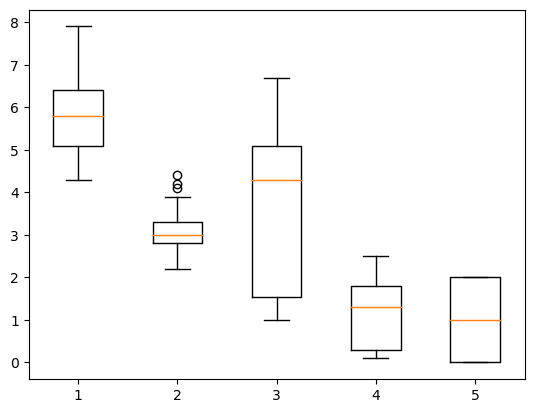

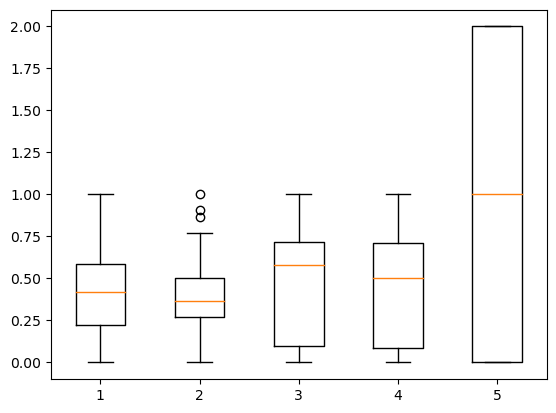

--


In [25]:

#  Boxplot, and normalize ..
#
#  Normalize from,
#     https://datascience.stackexchange.com/questions/39142/normalize-matrix-in-python-numpy
#

import matplotlib.pyplot as plt 
   #
from sklearn.preprocessing import MinMaxScaler

print(type(np_iris["train"]))

plt.boxplot(np_iris["train"])
plt.show()

   ###

def my_normalize(X, x_min, x_max):
   nom = (X-X.min(axis=0))*(x_max-x_min)
   denom = X.max(axis=0) - X.min(axis=0)
   denom[denom==0] = 1
   return x_min + nom/denom 

#  If we normalize the "class" column, we lose the categorical nature
#  of that data. So, create a deep copy, then just normalize the non-
#  class columns.
#
np_iris["train_norm"] = np.copy(np_iris["train"])
np_iris["test_norm" ] = np.copy(np_iris["test" ])
   #
np_iris["train_norm"][:, :4] = my_normalize(np_iris["train_norm"][:, :4], 0, 1)
np_iris["test_norm" ][:, :4] = my_normalize(np_iris["test_norm" ][:, :4], 0, 1)

plt.boxplot(np_iris["train_norm"])
plt.show()


print("--")


#  Step A2: Iris Data train, test .. NearestCentroid

In [26]:

from sklearn.neighbors import NearestCentroid

#  Our numpy array has 5 columns, with the last column being the class.
#  To review numpy array slicing,
#
#     To get the first 4 columns use,
#        np_iris["train"][:, :4]
#     To get the last column use,
#        np_iris["train"][:, -1]
#

do_model(NearestCentroid(), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: Centroid") 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

#  do_model(NearestCentroid(), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: Centroid Normalized") 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")
    

Iris: Centroid ...
   Actual    labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 1 1 2 2 1 0 1 0 0 2 0 1]
   Predicted labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 2 1 2 1 1 0 1 0 0 2 0 1]
   ###
   Accuracy: 93.3333 %

+----------------+------------+
| Category       |   Accuracy |
|----------------+------------|
| Iris: Centroid |    93.3333 |
+----------------+------------+
--


#  Step A3: Iris Data train, test .. kNN

In [27]:

from sklearn.neighbors import KNeighborsClassifier

#  Our numpy array has 5 columns, with the last column being the class.
#  To review numpy array slicing,
#
#     To get the first 4 columns use,
#        np_iris["train"][:, :4]
#     To get the last column use,
#        np_iris["train"][:, -1]
#

do_model(KNeighborsClassifier(n_neighbors = 3), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: kNN=3" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

#  do_model(KNeighborsClassifier(n_neighbors = 3), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: kNN=3 Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")


Iris: kNN=3 ...
   Actual    labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 1 1 2 2 1 0 1 0 0 2 0 1]
   Predicted labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 1 1 2 1 1 0 1 0 0 2 0 1]
   ###
   Accuracy: 96.6667 %

+----------------+------------+
| Category       |   Accuracy |
|----------------+------------|
| Iris: Centroid |    93.3333 |
| Iris: kNN=3    |    96.6667 |
+----------------+------------+
--


#  Step A4: Iris Data train, test .. Naive Bayes, Gaussian

In [28]:

from sklearn.naive_bayes import GaussianNB

#  Naive Bayes, Gaussian
#
#     Gaussian usually does better than the Multinomial below because,
#        Gaussian expects continuous values
#        Multinomial expects discreet values
#
#     And our values are continuous
#

do_model(GaussianNB(), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: GaussianNB" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

#  do_model(GaussianNB(), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: GaussianNB Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")


Iris: GaussianNB ...
   Actual    labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 1 1 2 2 1 0 1 0 0 2 0 1]
   Predicted labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 2 1 2 1 1 0 1 0 0 2 0 1]
   ###
   Accuracy: 93.3333 %

+------------------+------------+
| Category         |   Accuracy |
|------------------+------------|
| Iris: Centroid   |    93.3333 |
| Iris: kNN=3      |    96.6667 |
| Iris: GaussianNB |    93.3333 |
+------------------+------------+
--


#  Step A5: Iris Data train, test .. Naive Bayes, Multinomial

In [29]:

from sklearn.naive_bayes import MultinomialNB

#  Naive Bayes, Multinomial
#

do_model(MultinomialNB(), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: MultinomialNB" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

#  do_model(MultinomialNB(), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: MultinomialNB Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")


Iris: MultinomialNB ...
   Actual    labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 1 1 2 2 1 0 1 0 0 2 0 1]
   Predicted labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 2 1 2 2 1 0 1 0 0 2 0 1]
   ###
   Accuracy: 96.6667 %

+---------------------+------------+
| Category            |   Accuracy |
|---------------------+------------|
| Iris: Centroid      |    93.3333 |
| Iris: kNN=3         |    96.6667 |
| Iris: GaussianNB    |    93.3333 |
| Iris: MultinomialNB |    96.6667 |
+---------------------+------------+
--


#  Step A6: Iris Data train, test .. Decision Tree

In [30]:

from sklearn.tree import DecisionTreeClassifier

#  Decision Tree
#

do_model(DecisionTreeClassifier(), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: DecisionTree" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

#  do_model(DecisionTreeClassifier(), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: DecisionTree Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")


Iris: DecisionTree ...
   Actual    labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 1 1 2 2 1 0 1 0 0 2 0 1]
   Predicted labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 2 1 2 1 1 0 1 0 0 2 0 1]
   ###
   Accuracy: 93.3333 %

+---------------------+------------+
| Category            |   Accuracy |
|---------------------+------------|
| Iris: Centroid      |    93.3333 |
| Iris: kNN=3         |    96.6667 |
| Iris: GaussianNB    |    93.3333 |
| Iris: MultinomialNB |    96.6667 |
| Iris: DecisionTree  |    93.3333 |
+---------------------+------------+
--


#  Step A7: Iris Data train, test .. Random Forest

In [31]:

from sklearn.ensemble import RandomForestClassifier

#  Random Forest
#

#  n_estimators, number of random trees created and trained
#

do_model(RandomForestClassifier(n_estimators = 5), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: RandomForest" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

#  do_model(RandomForestClassifier(n_estimators = 5), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: RandomForest Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))

print("--")


Iris: RandomForest ...
   Actual    labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 1 1 2 2 1 0 1 0 0 2 0 1]
   Predicted labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 2 1 2 1 1 0 1 0 0 2 0 1]
   ###
   Accuracy: 93.3333 %

+---------------------+------------+
| Category            |   Accuracy |
|---------------------+------------|
| Iris: Centroid      |    93.3333 |
| Iris: kNN=3         |    96.6667 |
| Iris: GaussianNB    |    93.3333 |
| Iris: MultinomialNB |    96.6667 |
| Iris: DecisionTree  |    93.3333 |
| Iris: RandomForest  |    93.3333 |
+---------------------+------------+
--


#  Step A8: Iris Data train, test .. Support Vector Machine (SVM)

In [32]:

from sklearn.svm import SVC

#  Support Vector Machine
#
#  We run this one with a number of configurations ..
#
#     C      ==  margin constant
#     gamma  ==  used by the Gaussian kernel
#

do_model(SVC(kernel = "linear", C = 1.0), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: SVC/Linear" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
print()
             
#  do_model(SVC(kernel = "linear", C = 1.0), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: SVC/Linear Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
#  print()

             
do_model(SVC(kernel = "rbf", C = 1.0, gamma = 0.25), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: RBF" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
print()
             
#  do_model(SVC(kernel = "rbf", C = 1.0, gamma = 0.25), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: RBF Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
#  print()

             
do_model(SVC(kernel = "rbf", C = 1.0, gamma = 0.001), np_iris["train"][:, :4], np_iris["train"][:, -1], np_iris["test"][:, :4], np_iris["test"][:, -1], "Iris: RBF 2" ) 
print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
print()

#  do_model(SVC(kernel = "rbf", C = 1.0, gamma = 0.001), np_iris["train_norm"][:, :4], np_iris["train_norm"][:, -1], np_iris["test_norm"][:, :4], np_iris["test_norm"][:, -1], "Iris: RBF 2 Normalized" ) 
#  print()
#  print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
#  print()

print("--")


Iris: SVC/Linear ...
   Actual    labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 1 1 2 2 1 0 1 0 0 2 0 1]
   Predicted labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 1 1 2 2 1 0 1 0 0 2 0 1]
   ###
   Accuracy: 100.0000 %

+---------------------+------------+
| Category            |   Accuracy |
|---------------------+------------|
| Iris: Centroid      |    93.3333 |
| Iris: kNN=3         |    96.6667 |
| Iris: GaussianNB    |    93.3333 |
| Iris: MultinomialNB |    96.6667 |
| Iris: DecisionTree  |    93.3333 |
| Iris: RandomForest  |    93.3333 |
| Iris: SVC/Linear    |   100      |
+---------------------+------------+

Iris: RBF ...
   Actual    labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 1 1 2 2 1 0 1 0 0 2 0 1]
   Predicted labels from test......... [0 1 2 2 1 2 1 1 1 0 1 0 0 2 1 2 2 2 2 1 2 1 1 0 1 0 0 2 0 1]
   ###
   Accuracy: 93.3333 %

+---------------------+------------+
| Category            |   Accuracy |
|---------------

In [ ]:

####################################################################
####################################################################
####################################################################


#  Step B1:  Breast Cancer Data load, encode, normalize

In [33]:

#  Read the Breast Cancer data into a Pandas Dataframe
#
#     Features
#     1)     ID number
#     2)     Diagnosis (M = malignant, B = benign)
#     3-32)
#       Ten real-valued features are computed for each cell nucleus:
#     
#     	a) radius (mean of distances from center to points on the perimeter)
#     	b) texture (standard deviation of gray-scale values)
#     	c) perimeter
#     	d) area
#     	e) smoothness (local variation in radius lengths)
#     	f) compactness (perimeter^2 / area - 1.0)
#     	g) concavity (severity of concave portions of the contour)
#     	h) concave points (number of concave portions of the contour)
#     	i) symmetry 
#     	j) fractal dimension ("coastline approximation" - 1)
#
#  Sample data line,
#     842302,M,
#     17.99,    10.38,    122.8,    1001,    0.1184,    0.2776,    0.3001,    0.1471,    0.2419,    0.07871,         #  10 count
#     1.095,    0.9053,   8.589,    153.4,   0.006399,  0.04904,   0.05373,   0.01587,   0.03003,   0.006193,
#     25.38,    17.33,    184.6,    2019,    0.1622,    0.6656,    0.7119,    0.2654,    0.4601     ,0.1189
#

from sklearn.preprocessing import LabelEncoder

my_le = LabelEncoder()
   #
l_folder = "20_Data"
l_file   = "22_wdbc.data.txt"


pd_bc  = pd.read_csv((l_folder + "/" + l_file), header = 0, sep = ",",
   names = ["id", "class",
            "f01", "f02", "f03", "f04", "f05", "f06", "f07", "f08", "f09", "f10", 
            "f11", "f12", "f13", "f14", "f15", "f16", "f17", "f18", "f19", "f20", 
            "f21", "f22", "f23", "f24", "f25", "f26", "f27", "f28", "f29", "f30", 
           ],
   dtype = {"id": "int", "class": "string",
            "f01": "float", "f02": "float", "f03": "float", "f04": "float", "f05": "float", "f06": "float", "f07": "float", "f08": "float", "f09": "float", "f10": "float", 
            "f11": "float", "f12": "float", "f13": "float", "f14": "float", "f15": "float", "f16": "float", "f17": "float", "f18": "float", "f19": "float", "f20": "float", 
            "f21": "float", "f22": "float", "f23": "float", "f24": "float", "f25": "float", "f26": "float", "f27": "float", "f28": "float", "f29": "float", "f30": "float", 
           } )
      #
pd_bc["class_encoded"]  =  my_le.fit_transform(pd_bc["class"])
   #
pd_bc = pd_bc.drop(["class", "id"], axis = 1)
    
    
#  Pandas.Dataframe.sample() returns a randomized count of rows
#
print(tabulate(pd_bc.sample(5), headers='keys', tablefmt='psql', showindex=False))
print("Number of rows: %d" % (len(pd_bc)))

print("--")


+-------+-------+--------+--------+---------+---------+---------+----------+--------+---------+--------+--------+-------+-------+----------+----------+---------+----------+---------+----------+-------+-------+--------+--------+--------+--------+---------+---------+--------+---------+-----------------+
|   f01 |   f02 |    f03 |    f04 |     f05 |     f06 |     f07 |      f08 |    f09 |     f10 |    f11 |    f12 |   f13 |   f14 |      f15 |      f16 |     f17 |      f18 |     f19 |      f20 |   f21 |   f22 |    f23 |    f24 |    f25 |    f26 |     f27 |     f28 |    f29 |     f30 |   class_encoded |
|-------+-------+--------+--------+---------+---------+---------+----------+--------+---------+--------+--------+-------+-------+----------+----------+---------+----------+---------+----------+-------+-------+--------+--------+--------+--------+---------+---------+--------+---------+-----------------|
| 14.99 | 22.11 |  97.53 |  693.7 | 0.08515 | 0.1025  | 0.06859 | 0.03876  | 0.1944 | 0.059

In [34]:

#  Split data into training and test.
#  Convert the data into numpy arrays, since the ml libraries we use later expect that.
#

import numpy as np
from sklearn.model_selection import train_test_split

np_bc = {}
   #
np_bc["train"], np_bc["test"] = train_test_split(pd_bc.to_numpy(),                    #  random_state calls to shuffle the data,
   test_size = 0.20, random_state = 40)                                               #    which had arrived sorted
                                                                                      #  10% yields way too high of an accuracy
                                                                                      #    far below
print("Number of total rows: %d   Training rows: %d   Test rows: %d" %
  (len(pd_bc), len(np_bc["train"]), len(np_bc["test"])) )

print()
print("Train data:")
print("%s" % (np_bc["train"][0:5]))
print()
print("Test  data:")
print("%s" % (np_bc["test" ][0:5]))
print()
   #
print("--")


Number of total rows: 568   Training rows: 454   Test rows: 114

Train data:
[[12.1 14.6 78 449 0.103 0.0909 0.0659 0.0275 0.168 0.0604 0.264 0.729 1.85 19.9 0.00549 0.0143 0.0232 0.00566 0.0143 0.00242 13.8 20.7 89.9 583 0.149 0.216 0.305 0.0655 0.275 0.083 0]
 [15.7 11.3 103 747 0.104 0.13 0.119 0.0621 0.178 0.0626 0.163 0.387 1.14 13.9 0.00603 0.0182 0.0334 0.0107 0.0118 0.00226 17 14.2 112 854 0.154 0.298 0.4 0.145 0.256 0.0818 0]
 [14.3 16.8 90.3 633 0.0643 0.0267 0.00725 0.00625 0.151 0.0538 0.13 0.72 0.844 10.8 0.00349 0.00371 0.00483 0.00361 0.0154 0.00138 14.9 20.6 94.4 685 0.0857 0.0504 0.0387 0.0333 0.246 0.0612 0]
 [19.4 23.5 129 1.16e+03 0.103 0.156 0.205 0.0889 0.198 0.06 0.524 1.8 4.04 60.4 0.0106 0.0325 0.0391 0.0156 0.0219 0.00395 21.6 30.5 145 1.42e+03 0.146 0.297 0.346 0.156 0.292 0.0761 1]
 [10.2 17.5 65.1 313 0.106 0.085 0.0177 0.0192 0.191 0.0691 0.247 1.22 1.64 15.1 0.0079 0.014 0.00853 0.00762 0.0264 0.00376 11.2 22.8 71.9 376 0.141 0.144 0.0657 0.0558 0.305 0.0

Number of columns in matrix: 31


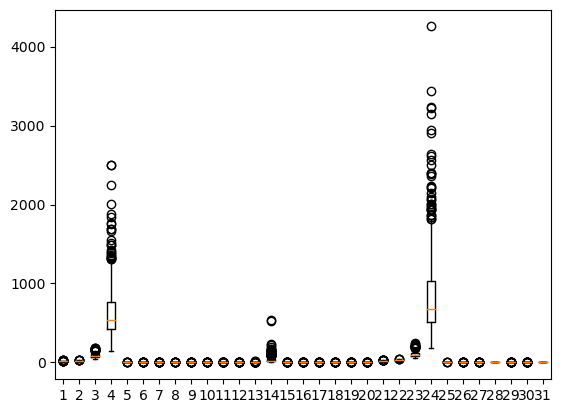

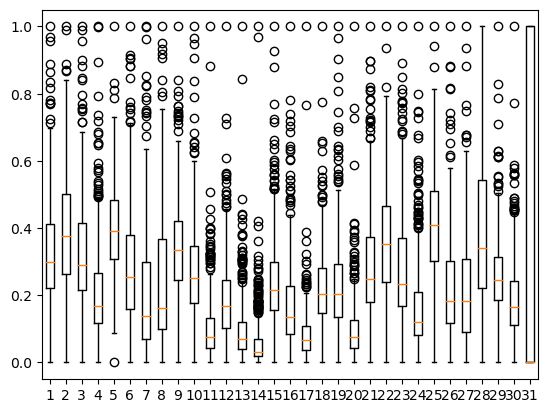

--


In [35]:

#  Normalizing the data
#

def my_normalize(X, x_min, x_max):
   nom = (X-X.min(axis=0))*(x_max-x_min)
   denom = X.max(axis=0) - X.min(axis=0)
   denom[denom==0] = 1
   return x_min + nom/denom 


print("Number of columns in matrix: %d" % (np_bc["train"].shape[1]))
      
#  If we normalize the "class" column, we lose the categorical nature
#  of that data. So, create a deep copy, then just normalize the non-
#  class columns.
#
np_bc["train_norm"] = np.copy(np_bc["train"])
np_bc["test_norm" ] = np.copy(np_bc["test" ])
   #
np_bc["train_norm"][:, :30] = my_normalize(np_bc["train_norm"][:, :30], 0, 1)
np_bc["test_norm" ][:, :30] = my_normalize(np_bc["test_norm" ][:, :30], 0, 1)

plt.boxplot(np_bc["train"     ])
plt.show()
plt.boxplot(np_bc["train_norm"])
plt.show()


print("--")


#  Step B2:  Breast Cancer Data, run against all models ..

In [ ]:

#  All of our model libraries were imported above, but ..
#
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


#  To add a blank line to history-
#
l_history.add(event = "", measure = "")


#  Our numpy array has many columns, with the last column being the class.
#
#  To review numpy array slicing,
#
#     To get the first 30 columns use,
#        np_iris["train"][:, :30]
#     To get the last column use,
#        np_iris["train"][:, -1]
#

do_model(NearestCentroid(), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: Centroid") 
#  do_model(NearestCentroid(), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: Centroid Normalized") 
print()

do_model(KNeighborsClassifier(n_neighbors = 3), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: kNN=3") 
do_model(KNeighborsClassifier(n_neighbors = 3), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: kNN=3 Normalized") 
print()

do_model(GaussianNB(), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: GaussianNB") 
do_model(GaussianNB(), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: GaussianNB Normalized") 
print()

do_model(MultinomialNB(), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: MultinomialNB") 
do_model(MultinomialNB(), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: MultinomialNB Normalized") 
print()

do_model(DecisionTreeClassifier(), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: DecisionTree") 
do_model(DecisionTreeClassifier(), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: DecisionTree Normalized") 
print()

#  n_estimators, number of random trees created and trained
#
do_model(RandomForestClassifier(n_estimators = 5), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: Random Forest = 5") 
do_model(RandomForestClassifier(n_estimators = 5), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: Random Forest = 5 Normalized") 
print()

   ###

#  Support Vector Machine
#
#  We run this one with a number of configurations ..
#
#     C      ==  margin constant
#     gamma  ==  used by the Gaussian kernel
#

do_model(SVC(kernel = "linear", C = 1.0), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: SVC/Linear") 
do_model(SVC(kernel = "linear", C = 1.0), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: SVC/Linear Normalized") 
print()

do_model(SVC(kernel = "rbf", C = 1.0, gamma = 1.0), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: RBF") 
do_model(SVC(kernel = "rbf", C = 1.0, gamma = 1.0), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: RBF Normalized") 
print()

do_model(SVC(kernel = "rbf", C = 1.0, gamma = 0.001), np_bc["train"][:, :30], np_bc["train"][:, -1], np_bc["test"][:, :30], np_bc["test"][:, -1], "Breast Cancer: RBF 2") 
do_model(SVC(kernel = "rbf", C = 1.0, gamma = 0.001), np_bc["train_norm"][:, :30], np_bc["train_norm"][:, -1], np_bc["test_norm"][:, :30], np_bc["test_norm"][:, -1], "Breast Cancer: RBF 2 Normalized") 
print()


print()
print(tabulate(l_history, headers=["Category", "Accuracy"], tablefmt='psql', showindex=False))
print()

print("--")
